# Hypothesis testing with the bootstrap
## The two-sample problem - FIDE ratings

Given the two independent samples from the same population, we would check if their distributions have the same mean.

We will be looking at the FIDE ranking as of November 12, 2021. We will single out two groups of male players - Polish and Russian players.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

np.random.seed(2)

In [2]:
df = pd.read_pickle('fide_ratings.pkl')
df

,fideid,country,sex,rating,birthday
0,25121731,IND,M,1063,1987.0
1,35077023,IND,M,1151,1986.0
2,10207538,BAN,M,1840,1974.0
3,10680810,EGY,M,1728,2001.0
4,5716365,MAS,M,1325,1970.0
...,...,...,...,...,...
373387,21836060,POL,M,1472,2006.0
373388,34190632,RUS,M,1884,1975.0
373389,24232602,RUS,M,1856,1993.0
373390,1189980,POL,M,1519,1999.0


In [3]:
pl = df[ (df['country'] == 'POL') & (df['sex'] == 'M')]['rating']
pl.describe()

count    9928.000000
mean     1615.495568
std       359.730344
min      1001.000000
25%      1316.000000
50%      1590.000000
75%      1899.250000
max      2756.000000
Name: rating, dtype: float64

In [4]:
ru = df[ (df['country'] == 'RUS') & (df['sex'] == 'M')]['rating']
ru.describe()

count    30677.000000
mean      1717.658702
std        386.551164
min       1001.000000
25%       1388.000000
50%       1743.000000
75%       2036.000000
max       2812.000000
Name: rating, dtype: float64

In [5]:
mean_diff = ru.mean() - pl.mean()
mean_diff_relative = mean_diff / pl.mean()
mean_diff, mean_diff_relative

(102.16313386887259, 0.06323950117030915)

On November 12, 2021, the average rating of Russian players was about 91 points higher than the average rating of Polish players - almost 6% of the average rating of Polish players.

$z = (z_1,...,z_n)$ - sample of ratings of Russian male players with unknown distribution $F$

$y = (y_1,...,y_m)$ - sample of ratings of Polish male players with unknown distribution $G$

$\mu_F, \mu_G$ - mean values of the distributions $F, G$

$x = (z_1,...,z_n,y_1,...,y_m)$

$H_0: \mu_F = \mu_G$

$H_a: \mu_F > \mu_G$

Let $X$ be a random variable denoting the distribution of the both Polish and Russian male players' rating.

The bootstrap hypothesis test is based on a test statistic $t(x)$. Wee seek an achieved significance level:
$$ASL = Prob_{H_0}(t(X) \geq t(x)).$$

In [6]:
n = math.floor(0.002*len(ru))
m = math.floor(0.005*len(pl))
alpha = 0.05 ### we seek strong evidence in a right-winged test
z = ru.sample(n = n, replace = False).values
y = pl.sample(n = m, replace = False).values
print(f'z:  length={len(z)}  min={np.min(z)}  max={np.max(z)}  mean={np.mean(z)}')
print(f'y:  length={len(y)}  min={np.min(y)}  max={np.max(y)}  mean={np.mean(y)}')

z:  length=61  min=1015  max=2421  mean=1699.4918032786886
y:  length=49  min=1083  max=2250  mean=1620.0


Since we are not willing to assume that the variances of the both distributions are equal, we base the test on
$$t(x) = \frac{\bar{z} - \bar{y}}{\sqrt{\bar{\sigma}_1^2 / n + \bar{\sigma}_2^2 / m}}$$
where:

$\bar{z}, \bar{y}$ - mean values of $z$ and $y$

$\bar{\sigma}_1^2 = \sum_{i=1}^{n}(z_i - \bar{z})^2/(n-1)$

$\bar{\sigma}_2^2 = \sum_{j=1}^{m}(y_j - \bar{y})^2/(m-1)$

We approximate ASL using the following algorithm:

### 1st step:

Let $\hat{F}$ put equal probability on the points

$\tilde{z}_i = z_i - \bar{z} + \bar{x}$ for $i=1,2,...,n$

and $\hat{G}$ put equal probability on the points

$\tilde{y}_j = y_j - \bar{y} + \bar{x}$ for $j=1,2,...,m$

where $\bar{x}$ is the mean of the combined sample.

### 2nd step:

Form $B$ bootstrap datasets $x^*_b = (z^*_b,y^*_b)$ where:

$z^*_b$ is sampled with replacement from $\tilde{z}_1,\tilde{z}_2,...,\tilde{z}_n$

$y^*_b$ is sampled with replacement from $\tilde{y}_1,\tilde{y}_2,...,\tilde{y}_m$

and $b = 1,2...,B$.

### 3th step:
For each $b=1,2,...,B$, evaluate
$$t(x^*_b) = \frac{\bar{z}^*_b - \bar{y}^*_b}{\sqrt{\bar{\sigma}_1^{*2} / n + \bar{\sigma}_2^{*2} / m}}$$

### 4th step:

Approximate $$\widehat{ASL} = \frac{\#\{t(x^*_b) \geq t(x)\ | b \in \{1,2,...,B\}\}}{B}.$$

#### The algorithm guarantees the convergence of $\widehat{ASL}$ to $ASL$ as $B \rightarrow \infty$.

In [7]:
def t_statistic(z, y):
    n = len(z)
    m = len(y)
    mean_z = np.mean(z)
    mean_y = np.mean(y)
    std_z = np.sum([(zi - mean_z)**2 for zi in z])/(n-1)
    std_y = np.sum([(yj - mean_y)**2 for yj in y])/(m-1)
    return (mean_z - mean_y) / np.sqrt(std_z/n + std_y/m)

In [8]:
t_stat = t_statistic(z, y)
t_stat

1.1533543412210565

In [9]:
def bootstrap_mean_test(z, y, B = 1000):
    n = len(z)
    m = len(y)
    mean_z = np.mean(z)
    mean_y = np.mean(y)
    t = t_statistic(z, y)
    
    x = np.concatenate((z, y), axis = 0)
    mean_x = np.mean(x)
    
    z_t = [(zi - mean_z + mean_x) for zi in z]
    y_t = [(yj - mean_y + mean_x) for yj in y]
    
    t_list = [] # list the t values to visualise
    cnt = 0
    
    for b in np.arange(B):
        z_b = np.random.choice(z_t, n, replace = True)
        y_b = np.random.choice(y_t, m, replace = True)
        
        t_b = t_statistic(z_b, y_b)
        t_list.append(t_b)
        
        if t_b >= t:
            cnt += 1
            
    asl = cnt / B
    return asl, t_list

In [10]:
asl, t_list = bootstrap_mean_test(z, y, B = 1000)

In [11]:
comp = 'below' if asl < alpha else 'above'
print(f'Probability of obtaining result as extreme as observed t-statistic is approximately ASL = {asl:.3f} which is {comp} the significance level alpha = {alpha}')

Probability of obtaining result as extreme as observed t-statistic is approximately ASL = 0.114 which is above the significance level alpha = 0.05


Text(0.5, 1.0, 'Test of the null hypothesis via bootstrap method')

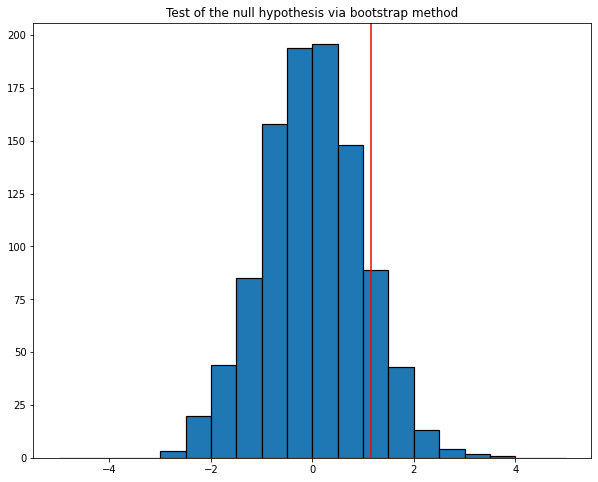

In [12]:
plt.figure(figsize = (10,8))
plt.hist(t_list, edgecolor='black', linewidth=1.2, bins = np.linspace(-5,5,21))
plt.axvline(x=t_stat, c='red')
plt.title('Test of the null hypothesis via bootstrap method')

We are confident enough to reject the null hypothesis and accept the alternative hypothesis: Russian male chess players have significantly higher mean rating than Polish male chess players.

#### Based on
An Introduction to the Bootstrap, 1993 - Bradley Efron, Robert J. Tibshirani

#### Data source
https://ratings.fide.com/